In [ ]:
from utils.imports import *

In [2]:
data_path = 'data'
DATA_ROOT = Path(data_path)

In [3]:
train_data = DATA_ROOT / "train"
test_data = DATA_ROOT / "test"

clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

# Merge clips for sanity checks
clips = pd.concat([clips_tr, clips_te]).reset_index()


In [ ]:
folder = Path("data/train/signals")
num_files = len(list(folder.glob("*")))

print(f"Total items in folder: {num_files}")

Total items in folder: 50


In [21]:
sig = clips_tr['signals_path'].unique()

# Target file to check
target_file = "signals/pqejgdjw_s005_t004.parquet"

# Check presence
if target_file in sig:
    print(f"{target_file} is present in clips_tr.")
else:
    print(f"{target_file} is NOT present in clips_tr.")

signals/pqejgdjw_s005_t004.parquet is present in clips_tr.


### 1. Analysis on session, segments and patient distribution

In [4]:
# Number of total segments
print(f'Total number of segments:{len(clips)}')

# Sampling rate -  Identical sampling rate for all signals

unique_rates = clips["sampling_rate"].unique()
print(f"Unique sampling rates: {unique_rates[0]}")
f_s = 250 # Define sampling frequency


# Signal duration

duration_signal = clips['end_time'] - clips['start_time']
print(f"Signal duration: {duration_signal.unique()[0]}")

# Number patients

unique_patients = clips["patient"].unique()
print(f"Number of patients: {len(unique_patients)}")
#print(any(clips.duplicated()))



Total number of segments:25986
Unique sampling rates: 250
Signal duration: 12.0
Number of patients: 97


In [ ]:


# Ocurrence of seizures for patients
patient_seizures = clips.groupby("patient")["label"].max()
print(patient_seizures.unique())
print('Some patients never have a seizure')
patient_no_seizures = patient_seizures.value_counts()[0]
patient_with_seizures = patient_seizures.value_counts()[1]
patients_nan_seizures  = patient_seizures[patient_seizures.isna()]

print(f"Number of patients that do not experience a seizure along all experiment: {patient_no_seizures}")
print(f"Number of patients that have at least a NaN: {patients_nan_seizures.size}")
print(f"Number of patients that have a seizure: {patient_with_seizures}")


[1 0]
Some patients never have a seizure
Number of patients that do not experience a seizure along all experiment: 1
Number of patients that have at least a NaN: 0
Number of patients that have a seizure: 96


In [7]:
patients_nan = np.array(patients_nan_seizures.index)
clips_reset = clips.reset_index()
clips_patient_nan = clips_reset[clips_reset['patient'].isin(patients_nan)]
print(f'Label values in patients with NaN in label: {clips_patient_nan.label.unique()}')
print('Patients with NaN in any of their labels, only have Nan')


Label values in patients with NaN in label: []
Patients with NaN in any of their labels, only have Nan


In [8]:

# Filter patients with NaN
clips = clips[~clips.label.isna()]
# Check all NaN removed
clips.label.isnull().any()

False

In [9]:
# Number sessions train and test
print(f'Number train sessions:{str(clips_tr.groupby(["patient","session"]).size().sum())}')
print(f'Number test sessions:{str(clips_te.groupby(["patient","session"]).size().sum())}')

Number train sessions:12993
Number test sessions:12993


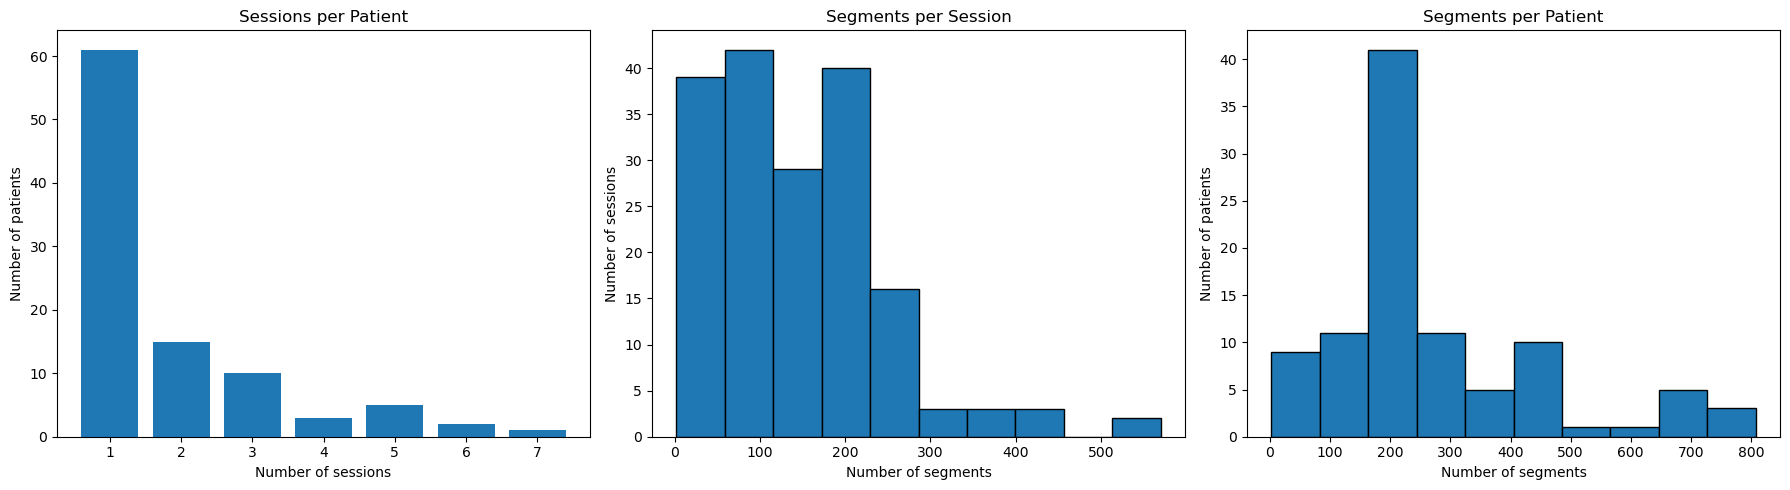

In [10]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Number of sessions per patient
patient_sessions = clips.groupby("patient")["session"].nunique().value_counts().sort_index()
axes[0].bar(patient_sessions.index, patient_sessions.values)
axes[0].set_title("Sessions per Patient")
axes[0].set_xlabel("Number of sessions")
axes[0].set_ylabel("Number of patients")

# 2. Distribution of segments per session
segments_per_session = clips.groupby(["patient", "session"]).size()
axes[1].hist(segments_per_session.values, edgecolor='black')
axes[1].set_title("Segments per Session")
axes[1].set_xlabel("Number of segments")
axes[1].set_ylabel("Number of sessions")

# 3. Segments per patient
# Count total number of segments per patient
segments_per_patient = clips.groupby("patient").size()

axes[2].hist(segments_per_patient.values, edgecolor='black')
axes[2].set_title("Segments per Patient")
axes[2].set_xlabel("Number of segments")
axes[2].set_ylabel("Number of patients")

plt.tight_layout()
plt.show()

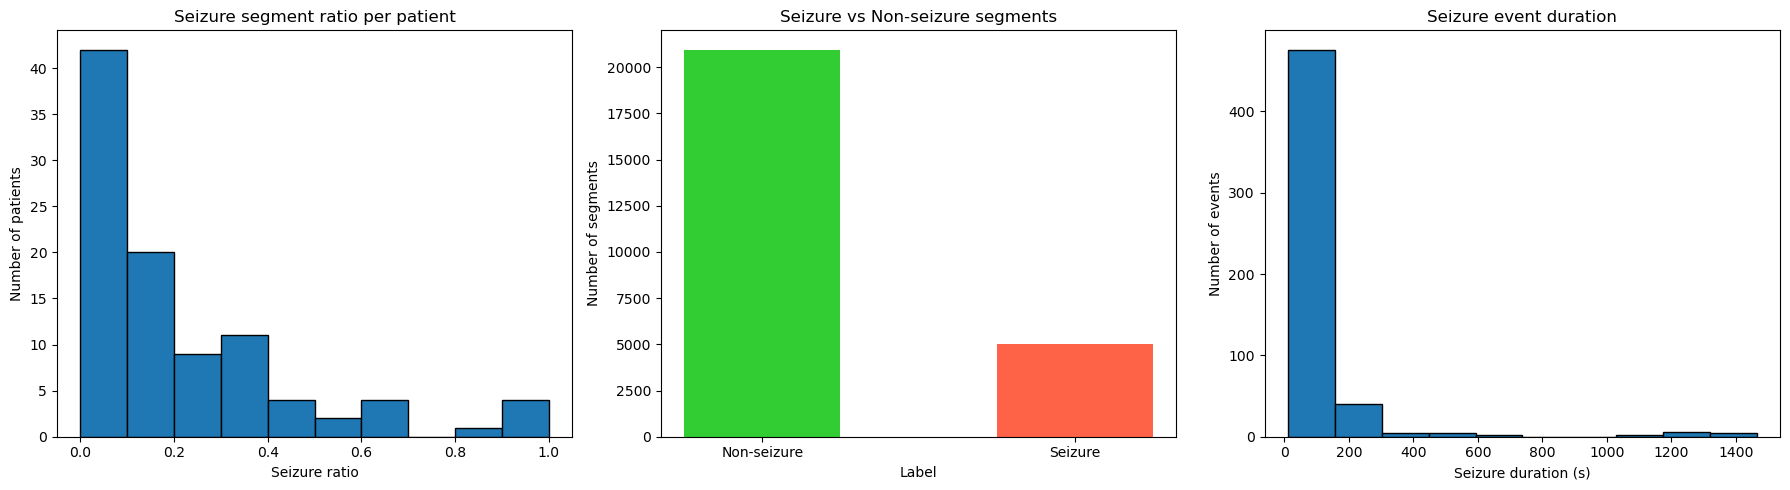

In [11]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Seizure ratio per patient
seizure_ratio = clips.groupby("patient")["label"].mean()
axes[0].hist(seizure_ratio, edgecolor='black')
axes[0].set_title("Seizure segment ratio per patient")
axes[0].set_xlabel("Seizure ratio")
axes[0].set_ylabel("Number of patients")

# 2. Seizure and non-seizure segment distribution
label_counts = clips["label"].value_counts().sort_index()
axes[1].bar(label_counts.index, label_counts.values, width=0.5, color=["limegreen", "tomato"])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Non-seizure", "Seizure"])
axes[1].set_title("Seizure vs Non-seizure segments")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Number of segments")

# 3. Seizure event durations
def duration_seizure(clips):
    seizure_duration = []
    seizure_t = 0
    for _, row in clips.iterrows():
        if row["label"] == 1:
            seizure_t += 1
        elif seizure_t != 0:
            seizure_duration.append(seizure_t)
            seizure_t = 0
    if seizure_t != 0:
        seizure_duration.append(seizure_t)  # edge case at end
    return [d * 12 for d in seizure_duration]  # assuming 12s per segment

durations = duration_seizure(clips)
axes[2].hist(durations, edgecolor='black')
axes[2].set_title("Seizure event duration")
axes[2].set_xlabel("Seizure duration (s)")
axes[2].set_ylabel("Number of events")

plt.tight_layout()
plt.show()

### Insights



- **Data Volume and Structure**:
   - The dataset contains a total of 16,607 EEG signal segments across 122 patients, all sampled at 250 Hz with a duration of 12 seconds per segment.

- **Patient and Session Variability**:
  - Most patients have only **one session**, though a few have up to 7.
  - Segment count per session varies widely, with many sessions containing fewer than 150 segments.
  - At the patient level, segment counts are mostly concentrated between 50 and 200.

- **Seizure Distribution**:
  - Only one patient does not experience any seizure.
  - There is a significant **class imbalance**, with seizure segments being much less frequent than non-seizure segments (~2,500 vs ~10,500) -> **Oversampling strategies**
  - Seizure segment ratios per patient are mostly low (<0.2), indicating seizures are rare for most individuals.
  - Seizure event durations are typically short (<200s), though a few outliers exceed 1000s.

- **Missing Data**:
  - 25 patients had only `NaN` values in their labels and were removed from the dataset.
  - The remaining dataset was successfully cleaned, and no missing labels remain.

- **Train/Test Split**:
  - The training set consists of 12,993 segments.
  - The test set contains 3,614 segments.

.


### 2. Channel information

In [13]:
# Number of channels

example_sample = pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"])
n_channels = len(example_sample.columns)
print(f"Number of channels: {n_channels}")
channels = list(example_sample.columns)
print(f"Channels: {channels}")


example_sample.head()

Number of channels: 19
Channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Frequency visualization and preprocessing

In [ ]:
# Selecting one segment (EXAMPLE)
f_s = 250
row = clips_tr.iloc[0]
start = int(row["start_time"] * f_s)
end =  int(row["end_time"] * f_s)
signal = pd.read_parquet(DATA_ROOT / "train" / row["signals_path"])
segment = signal.iloc[start:end]

# Visualize frequencies
visualize_frequencies(segment) 
# VERY EVIDENT POWER LINE FREQUENCY

**3.1 FILTERING**

- **Band-pass filter**
   - Doubts whether to apply bandpass filter with maximum threshold at 30/50 Hz (different criteria literature):
      - From **Random Forest** classifier: theta band frequency (30-50 Hz): the most important -> Apply upper bound for frequency at 50 Hz.
   
- **Notch filter**
  - Sharp, narrow spike ar f = 60 Hz (in almost all channels).
    - Power line interference: frequency of power grid
    - Since f = 60 Hz -> recordings originated in the USA or Canada (Europe: 50 Hz)



**Insights**

- Since THE  narrowband, it could survive bandpass filter.
- Bandpass first → more stable, clean signal for notch filter to act on


In [ ]:
# i. ---------------- Bandpass filter ----------------------------------
f_s =250 # sampling frequency
bp_filter = signal.butter(4, (0.5, 50), btype="bandpass", output="sos", fs=f_s)
 # Experiment with diff. frequencies bandpass filters

# ii. ---------------- Notch filter -------------------------------------------
# Remove 60 Hz frequency from signal
notch_filter = signal.iirnotch(w0=60, Q=30, fs=f_s)
notch_filter = signal.tf2sos(*notch_filter) # Need to convert to SOS format (same formar as bp_filter) for numerical stability


filtered_segment = time_filtering(segment.values, bp_filter, notch_filter) # filtered signals
segment_filtered = pd.DataFrame(filtered_segment, columns=channels)
visualize_frequencies(segment_filtered)

### 4. Feature extraction

**Feature Selection Rationale**

The selected features capture both **temporal** and **spectral** characteristics of EEG signals:

- **Time/Shape Features**:  
  Capture signal morphology and complexity over time.  
  - `rms`: measures signal energy.  
  - `linelen`: reflects waveform complexity and spikiness.  
  - `hj_mob`, `hj_cmp`: Hjorth parameters quantify signal mobility and structural complexity.

- **Spectral Features**:  
  Capture frequency content and brain rhythm dynamics.  
  - Band powers (`alpha`, `beta`, `theta`, `gamma`) describe brain state activity.  
  - `spec_ent`: measures spectral irregularity (e.g., seizures may reduce entropy).  
  - `rel_*` and `theta_alpha_ratio`: normalized markers often used in seizure detection and cognitive state assessment.


In [14]:

# 5 time / shape features
time_features = [
    "rms",          # Root-mean-square amplitude
    "linelen",      # line length
    "hj_mob",       # Hjorth mobility
    "hj_cmp",       # Hjorth complexity
]

# 7 spectral features
freq_features = [
    'spec_ent',     # spectral entropy
    "alpha_pow",    # absolute power
    "beta_pow",
    "theta_pow",
    "gamma_pow",
    "rel_alpha",    # power / total
    "rel_theta",
    "theta_alpha_ratio",   # θ / α balance marker
]



In [15]:
all_features = time_features + freq_features

# ------------------------------------------------------------------
feature_names = [f"{feat}_{ch}"
                 for ch in channels
                 for feat in all_features]

print(f"Total features: {len(feature_names)}")
print(feature_names[:20], "...")

Total features: 228
['rms_FP1', 'linelen_FP1', 'hj_mob_FP1', 'hj_cmp_FP1', 'spec_ent_FP1', 'alpha_pow_FP1', 'beta_pow_FP1', 'theta_pow_FP1', 'gamma_pow_FP1', 'rel_alpha_FP1', 'rel_theta_FP1', 'theta_alpha_ratio_FP1', 'rms_FP2', 'linelen_FP2', 'hj_mob_FP2', 'hj_cmp_FP2', 'spec_ent_FP2', 'alpha_pow_FP2', 'beta_pow_FP2', 'theta_pow_FP2'] ...
